[Source code](https://github.com/alun/strategies/blob/master/stoken.ipynb)

- S&P 500 (SPY) vs Intermediate-term US Treasuries (IEF)
- Gold (GLD) vs Long-term US Treasuries (TLT)
- US Real Estate (VNQ) vs Intermediate-term US Treasuries (IEF)


![strategy_params](strategy_params.png)


[More info](https://allocatesmartly.com/stokens-active-combined-asset-strategy/)

IEF - 7-10 years bonds

TLT - 20+ bonds


In [1]:
CONFIG = {
  'SPY': {'upper': 126, 'lower': 252, 'defensive_asset': 'IEF'},
  'GLD': {'upper': 252, 'lower': 126, 'defensive_asset': 'TLT'},
  'VNQ': {'upper': 126, 'lower': 252, 'defensive_asset': 'IEF'}
}

In [2]:
import numpy as np

ASSETS = set(np.array([
  [asset, config['defensive_asset']] 
    for (asset, config) in CONFIG.items()
]).flat)

print(f'All assets used: {ASSETS}')

All assets used: {'TLT', 'VNQ', 'SPY', 'IEF', 'GLD'}


# Stoken's ACA Strategy

# Load assets history

We will use yahoo finance client to load dividends and prices history for our `ASSETS`.

In [3]:
# pip install --user pandas numpy datetime scipy pandas_datareader yfinance

import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from datetime import datetime, date, timedelta

yf.pdr_override()

In [4]:
def load_max_history(assets):
  df = None

  for asset in assets:
    data = yf.Ticker(asset).history(period='max')
    columns = pd.MultiIndex.from_product(
      [data.columns, [asset]],
      names=['property', 'asset']
    )
    multi_level_df = pd.DataFrame(data.values, index=data.index, columns=columns)
    # display(multi_level_df.columns.to_numpy())
    if df is None:
      df = multi_level_df
    else:
      df = df.join(multi_level_df)

  df = df[sorted(df.columns)]
  return df.dropna()

df = load_max_history(ASSETS)[['Close', 'Dividends']]
df.head()

property        Close                                             Dividends  \
asset             GLD        IEF        SPY        TLT        VNQ       GLD   
Date                                                                          
2004-11-18  44.380001  54.958904  84.752518  51.478996  25.282887       0.0   
2004-11-19  44.779999  54.657681  83.810364  51.068188  25.021564       0.0   
2004-11-22  44.950001  54.696171  84.210083  51.334320  25.194216       0.0   
2004-11-23  44.750000  54.644913  84.338539  51.398003  25.301559       0.0   
2004-11-24  45.049999  54.721767  84.538368  51.398003  25.740200       0.0   

property                        
asset       IEF  SPY  TLT  VNQ  
Date                            
2004-11-18  0.0  0.0  0.0  0.0  
2004-11-19  0.0  0.0  0.0  0.0  
2004-11-22  0.0  0.0  0.0  0.0  
2004-11-23  0.0  0.0  0.0  0.0  
2004-11-24  0.0  0.0  0.0  0.0

# Stategy evaluaton

Create upper and lower channels for risk-on assets defined in the `CONFIG`.

In [5]:
from operator import itemgetter

In [6]:
for (risk_asset, config) in CONFIG.items():
  (upper_channel_window, lower_channel_window) = itemgetter('upper', 'lower')(config)
  close_prices = df.Close[risk_asset]

  df['Upper_Channel', risk_asset] = close_prices\
    .rolling(window=upper_channel_window).max().shift(1)
  df['Lower_Channel', risk_asset] = close_prices\
    .rolling(window=lower_channel_window).min().shift(1)

df = df[sorted(df.columns)]

In [7]:
df.iloc[250:].head() # deliberate shift to check the first moment where 252 lower/upper channel appeared for the first time

property        Close                                             Dividends  \
asset             GLD        IEF        SPY        TLT        VNQ       GLD   
Date                                                                          
2005-11-15  46.660000  55.152008  89.464462  54.095654  29.501305       0.0   
2005-11-16  47.779999  55.431480  89.645927  54.664459  29.333401       0.0   
2005-11-17  48.480000  55.537956  90.480759  54.797565  29.817347       0.0   
2005-11-18  48.459999  55.404873  90.836479  54.543396  29.925999       0.0   
2005-11-21  48.990002  55.511299  91.293839  54.706787  30.074144       0.0   

property                       Lower_Channel                        \
asset       IEF  SPY  TLT  VNQ           GLD        SPY        VNQ   
Date                                                                 
2005-11-15  0.0  0.0  0.0  0.0     41.529999        NaN        NaN   
2005-11-16  0.0  0.0  0.0  0.0     41.529999        NaN        NaN   
2005-11-17  0.0  0.0  0.0  0.0     41.529999  81.930771  24.664757   
2005-11-18  0.0  0.0  0.0  0.0     41.529999  81.930771  24.664757   
2005-11-21  0.0  0.0  0.0  0.0     41.529999  81.930771  24.664757   

property   Upper_Channel                       
asset                GLD        SPY       VNQ  
Date                                           
2005-11-15           NaN  90.155098  30.90321  
2005-11-16           NaN  90.155098  30.90321  
2005-11-17     47.779999  90.155098  30.90321  
2005-11-18     48.480000  90.480759  30.90321  
2005-11-21     48.480000  90.836479  30.90321

In [8]:
df.iloc[124:].head() # deliberate shift to check the first moment where 126 lower/upper channel appeared for the first time

property        Close                                             Dividends  \
asset             GLD        IEF        SPY        TLT        VNQ       GLD   
Date                                                                          
2005-05-18  42.049999  56.255859  85.523354  55.349045  27.330290       0.0   
2005-05-19  41.980000  56.086143  85.883324  55.207096  27.692444       0.0   
2005-05-20  41.650002  56.079617  85.760948  55.272148  27.750381       0.0   
2005-05-23  41.619999  56.334221  86.236092  55.703918  27.813145       0.0   
2005-05-24  41.730000  56.484341  86.034500  55.857761  27.426868       0.0   

property                       Lower_Channel         Upper_Channel             \
asset       IEF  SPY  TLT  VNQ           GLD SPY VNQ           GLD        SPY   
Date                                                                            
2005-05-18  0.0  0.0  0.0  0.0           NaN NaN NaN           NaN        NaN   
2005-05-19  0.0  0.0  0.0  0.0           NaN NaN NaN           NaN        NaN   
2005-05-20  0.0  0.0  0.0  0.0     41.259998 NaN NaN           NaN  88.057274   
2005-05-23  0.0  0.0  0.0  0.0     41.259998 NaN NaN           NaN  88.057274   
2005-05-24  0.0  0.0  0.0  0.0     41.259998 NaN NaN           NaN  88.057274   

property               
asset             VNQ  
Date                   
2005-05-18        NaN  
2005-05-19        NaN  
2005-05-20  27.692444  
2005-05-23  27.750381  
2005-05-24  27.813145

In [9]:
from dotmap import DotMap
import rpar

SLIPPAGE = 0.01
FEE = 0.02
TAX = 0.15 # we pay 15% tax on dividends here (but it can vary a lot depending on circumstances)

cash = 50000 # initial cash
portfolio = []

def flatten_portfolio(portfolio): 
  dict = {}
  for item in portfolio:
    dict[item['asset']] = item['amount']
  return dict

results = DotMap(portfolio_value=[], cash=[], portfolio=[], last_fractions=[])
# TODO add turnaround
total = DotMap(fees=0, volume=0)

RISK_BALANCE_WINDOW = float('inf')
# RISK_BALANCE_WINDOW = 256

# history = df.iloc[0:5]
history = df
for x in range(0, len(history)):

  today = history.iloc[x]
  close_price = today.Close
  dividends = today.Dividends

  fractions = {}

  # initialize portfolio - start with risk on
  if len(portfolio) == 0:
    portfolio = [{}] * len(CONFIG)
    assets = CONFIG.keys()
    portfolio_value = cash
    fractions = dict(zip(assets, [1 / len(assets)] * len(assets)))

    for (index, (asset, config)) in enumerate(CONFIG.items()):
      portfolio[index] = {'asset': asset, 'amount': 0}
      # we will open positions later during the rebalance phase

  # add dividends
  for item in portfolio:
    (asset, amount) = itemgetter('asset', 'amount')(item)
    maybe_divs = dividends[asset]
    if not np.isnan(maybe_divs):
      cash += (amount * maybe_divs) * (1 - TAX) 

  # check if need to replace some assets with defensive assets
  upper_channel = today.Upper_Channel
  lower_channel = today.Lower_Channel

  new_assets = []

  for (index, (risk_asset, config)) in enumerate(CONFIG.items()):
    my_asset = portfolio[index]['asset']
    if not pd.isna(upper_channel[risk_asset]) and close_price[risk_asset] > upper_channel[risk_asset]:
      new_assets.append(risk_asset)
    elif not pd.isna(lower_channel[risk_asset]) and close_price[risk_asset] < lower_channel[risk_asset]:
      new_assets.append(config['defensive_asset'])
    else:
      new_assets.append(my_asset)

  needs_rotation = any(new_asset != item['asset'] for (new_asset, item) in zip(new_assets, portfolio))
  if needs_rotation:
    # maybe update risk balanced weights based on the previous RISK_BALANCE_WINDOW prices
    # note: if RISK_BALANCE_WINDOW = float('inf') this will never happen in this case - always use equal weight
    fractions = dict(zip(new_assets, [1 / len(new_assets)] * len(new_assets)))
    if x > RISK_BALANCE_WINDOW:
      fractions = dict(rpar.get_weights(df.iloc[x - RISK_BALANCE_WINDOW:x].Close[new_assets]))
      # this protects from cases when a single asset is repeated twice e.g. IEF/GLD/IEF state
      for (k, v) in fractions.items():
        if isinstance(fractions[k], pd.Series): 
          fractions[k] = v[0]

    for (index, item) in enumerate(portfolio):
      # do we need to replace the item (i.e. switch risk/defensive)
      if new_assets[index] != item['asset']:
        # sell current asset, we will buy new asset later during rebalance
        (asset, amount) = itemgetter('asset', 'amount')(item)
        cash += amount * (close_price[asset] - SLIPPAGE)

        fee = amount * FEE
        cash -= fee
        total.fee += fee
        total.volume += amount

        item['asset'] = new_assets[index] 
        item['amount'] = 0

  # calculate current portfolio value
  portfolio_value = cash
  for item in portfolio:
    (asset, amount) = itemgetter('asset', 'amount')(item)
    portfolio_value += (close_price[asset] - SLIPPAGE - FEE) * amount

  if len(fractions) == 0: 
    fractions = results.last_fractions[-1] 

  for item in portfolio:
    asset = item['asset']
    price = close_price[asset]
    new_amount = np.floor(portfolio_value * fractions[asset] / price)
    diff = item['amount'] - new_amount
    if diff != 0:
      # rebalance
      if diff > 0: # => item['amount'] > new_amount => sell
        cash += abs(diff) * (price - SLIPPAGE)
      else: # => item['amount'] < new_amount => buy
        cash -= abs(diff) * (price + SLIPPAGE)

      fee = abs(diff) * FEE
      cash -= fee
      total.fee += fee
      total.volume += abs(diff)

      item['amount'] = new_amount

  # calculate updated portfolio value
  portfolio_value = cash
  for item in portfolio:
    (asset, amount) = itemgetter('asset', 'amount')(item)
    portfolio_value += (close_price[asset] - SLIPPAGE - FEE) * amount

  results.portfolio_value.append(portfolio_value)
  results.cash.append(cash)
  results.portfolio.append(flatten_portfolio(portfolio))
  results.last_fractions.append(fractions)

result_df = pd.DataFrame(results, index=history.index)

# dumping results dataframe to HTML can be good for debug purposes
#
# with open('out.html', 'w') as file:
#   file.write(history.join(result_df).to_html())


## Portfolio states

In [10]:
result_df.head()

,portfolio_value,cash,portfolio,last_fractions
Date,,,,
2004-11-18,49926.200000,47.683923,"{'SPY': 196.0, 'GLD': 375.0, 'VNQ': 659.0}","{'SPY': 0.3333333333333333, 'GLD': 0.333333333..."
2004-11-19,49719.085759,112.438860,"{'SPY': 197.0, 'GLD': 370.0, 'VNQ': 662.0}","{'SPY': 0.3333333333333333, 'GLD': 0.333333333..."
2004-11-22,49975.026338,137.603076,"{'SPY': 197.0, 'GLD': 370.0, 'VNQ': 661.0}","{'SPY': 0.3333333333333333, 'GLD': 0.333333333..."
2004-11-23,49997.166078,123.857754,"{'SPY': 197.0, 'GLD': 372.0, 'VNQ': 658.0}","{'SPY': 0.3333333333333333, 'GLD': 0.333333333..."
2004-11-24,50436.637639,122.760387,"{'SPY': 198.0, 'GLD': 373.0, 'VNQ': 653.0}","{'SPY': 0.3333333333333333, 'GLD': 0.333333333..."


In [11]:
result_df.tail()

,portfolio_value,cash,portfolio,last_fractions
Date,,,,
2022-03-09,417063.234420,281.880599,"{'SPY': 325.0, 'GLD': 748.0, 'VNQ': 1333.0}","{'SPY': 0.3333333333333333, 'GLD': 0.333333333..."
2022-03-10,417216.339604,542.520576,"{'SPY': 326.0, 'GLD': 746.0, 'VNQ': 1330.0}","{'SPY': 0.3333333333333333, 'GLD': 0.333333333..."
2022-03-11,413371.397796,176.080552,"{'SPY': 328.0, 'GLD': 744.0, 'VNQ': 1329.0}","{'SPY': 0.3333333333333333, 'GLD': 0.333333333..."
2022-03-14,409211.953633,172.220541,"{'SPY': 327.0, 'GLD': 748.0, 'VNQ': 1326.0}","{'SPY': 0.3333333333333333, 'GLD': 0.333333333..."
2022-03-16,412557.197626,243.516424,"{'SPY': 319.0, 'GLD': 771.0, 'VNQ': 1319.0}","{'SPY': 0.3333333333333333, 'GLD': 0.333333333..."


# Total annualized returns

In [12]:
first = result_df.iloc[0]
last = result_df.iloc[-1]

years = (last.name - first.name).days / 365.25

annualized_return = (last['portfolio_value']  / first['portfolio_value']) ** (1/years) - 1

print(
  """Annualized return is: %.2f%%
over the period of %.2f years
from %s to %s""" % (
    100 * annualized_return,
    years,
    date.fromtimestamp(first.name.timestamp()), 
    date.fromtimestamp(last.name.timestamp())
  )
)


Annualized return is: 12.97%
over the period of 17.32 years
from 2004-11-18 to 2022-03-16


# Overall performance

In [13]:
print(f'Fees paid {total.fee:.2f}')
print(f'Volume traded {total.volume:.2f} stocks')

Fees paid 1803.70
Volume traded 90185.00 stocks


## Free cash

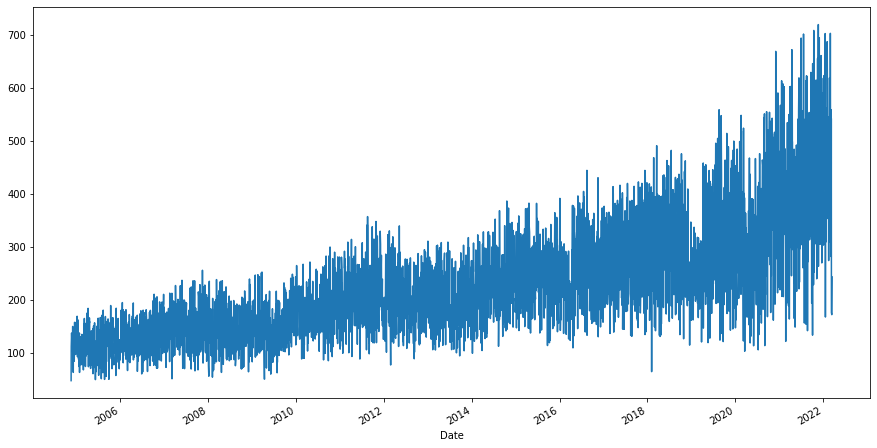

In [14]:
result_df.cash.plot(figsize=(15, 8))

## Equity

Initial investment at 2004-11-18: 10000
Last value at 2022-03-16: 82633.41


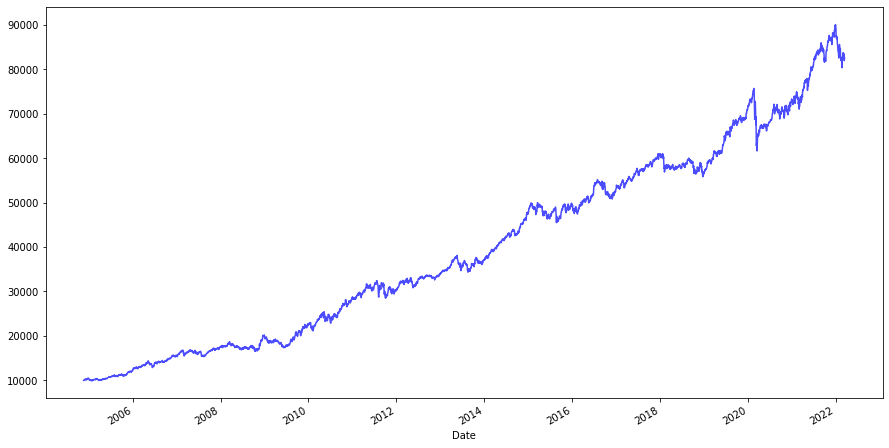

In [15]:
log_returns = np.log(result_df.portfolio_value).diff()

cum_returns = log_returns.cumsum() 

CAPITAL = 10000

perf = CAPITAL * np.exp(cum_returns)
plt.figure()
perf.plot(figsize=(15,8), color='b', alpha=0.7)

print(f'Initial investment at {perf.index[0].date()}: {CAPITAL}')
print(f'Last value at {perf.index[-1].date()}: {perf[-1]:.2f}')

In [16]:
TRADING_DAYS_YEARLY = 252
# RISK_FREE_RATE = 0.02
RISK_FREE_RATE = 0.00

annual_return = np.exp(log_returns.mean() * TRADING_DAYS_YEARLY) - 1
annual_volatility = log_returns.std() * np.sqrt(TRADING_DAYS_YEARLY)

sharpe_ratio = (annual_return - RISK_FREE_RATE) / annual_volatility

annualized_downside = log_returns.loc[log_returns<0].std() * np.sqrt(TRADING_DAYS_YEARLY)
sortino_ratio = (annual_return - RISK_FREE_RATE) / annualized_downside  

sortino_ratio = (annual_return - RISK_FREE_RATE) / annualized_downside  

print(
  f"""Annulaized return {(annual_return * 100):.2f}%
Annualized volatility {(annual_volatility * 100):.2f}%
Sharpe ratio {sharpe_ratio:.2f}
Sortino ratio {sortino_ratio:.2f}
""" 
)

Annulaized return 12.99%
Annualized volatility 11.16%
Sharpe ratio 1.16
Sortino ratio 1.54



# Returns by month/by year

In [17]:

def montly_results(result_df):
  initial_value = result_df['portfolio_value'][0]

  grouping = pd.MultiIndex.from_tuples(
    zip(result_df.index.year, result_df.index.month),
    names=['year', 'month']
  )

  by_month = result_df.groupby(by=grouping).last()[['portfolio_value']]
  by_month = by_month.join(by_month.shift(1).add_prefix('prev_')).fillna(initial_value)

  table = pd.DataFrame(
    {
      'change': 100 * (by_month['portfolio_value'] / by_month['prev_portfolio_value'] - 1),
    },
    index = grouping
  ).dropna().reset_index()

  montly_results = table.pivot_table(index=['year'], columns=['month'], values=['change'])

  grouping = result_df.index.year
  by_year = result_df.groupby(by=grouping).last()[['portfolio_value']]
  by_year = by_year.join(by_year.shift(1).add_prefix('prev_')).fillna(initial_value)

  montly_results['total'] = 100 * (by_year['portfolio_value'] / by_year['prev_portfolio_value'] - 1)

  return montly_results

pd.options.display.float_format = lambda x: 'N/A' if np.isnan(x) else '{:,.2f}%'.format(x)
display(montly_results(result_df))
pd.options.display.float_format = None 


change                                                                 \
month      1      2      3      4      5      6      7      8      9     10   
year                                                                          
2004     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2005  -4.81%  2.82% -0.85%  1.69%  0.90%  3.83%  3.14% -1.20%  4.09% -1.92%   
2006   6.61%  0.48%  3.87%  3.19% -2.23%  0.95%  2.54%  1.45%  0.73%  3.51%   
2007   4.26% -0.69% -0.19%  2.12%  0.25% -3.37% -3.53%  1.78%  5.12%  3.29%   
2008   1.61%  2.84% -0.85% -2.69% -1.25% -0.93%  1.30% -0.94%  1.96% -5.76%   
2009  -7.02% -0.67%  3.88% -3.85% -2.27% -0.71%  2.77%  6.98%  4.41% -0.87%   
2010  -3.46%  4.01%  5.74%  4.93% -3.33% -2.02%  3.65% -0.07%  6.71%  4.10%   
2011  -0.31%  4.74%  0.51%  5.85% -0.49% -1.91%  2.62%  0.59% -8.90%  4.97%   
2012   5.25%  0.10%  2.85%  0.70% -4.46%  3.30%  2.45%  0.48% -0.02% -0.96%   
2013   1.85%  1.36%  2.63%  4.56% -3.42% -1.51%  1.34% -3.68%  3.09%  3.63%   
2014   2.29%  3.48%  1.20%  2.14%  2.66%  1.60% -0.09%  4.01% -2.60%  5.12%   
2015   4.51% -1.41%  0.88% -2.70% -0.37% -2.95%  4.30% -4.22%  1.51%  4.66%   
2016  -0.96% -0.60%  3.57%  0.56% -0.76%  5.97%  3.33% -2.29%  0.05% -3.45%   
2017   0.82%  3.09% -0.53%  1.02%  0.94%  1.77%  0.95%  1.22%  0.42%  0.48%   
2018  -0.93% -4.10% -0.11% -0.49%  0.80% -0.21%  1.02%  2.44% -1.00% -4.12%   
2019   4.19% -0.27%  4.51% -0.27%  0.16%  5.16%  1.10%  3.35%  0.55%  2.00%   
2020   1.91% -5.16% -5.41%  2.66%  1.14%  1.00%  4.13%  0.93% -2.35% -1.40%   
2021  -1.34%  0.22%  1.72%  5.25%  0.55%  3.49%  3.61%  1.64% -4.09%  5.59%   
2022  -5.82% -2.59%  0.00%    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

                     total  
month     11     12         
year                        
2004   0.94%  3.14%  4.11%  
2005   4.80%  3.37% 16.52%  
2006   4.60%  0.49% 29.21%  
2007  -0.26%  2.35% 11.24%  
2008  10.39%  8.77% 14.22%  
2009   8.53%  1.38% 12.06%  
2010   0.12%  5.26% 27.95%  
2011  -0.35% -0.84%  5.76%  
2012   0.53%  1.60% 12.13%  
2013  -1.61%  1.28%  9.49%  
2014   2.66%  2.53% 27.80%  
2015  -0.28%  0.81%  4.34%  
2016  -1.38%  3.20%  7.03%  
2017   2.23%  1.77% 15.10%  
2018   2.87% -3.00% -6.89%  
2019  -0.32%  2.93% 25.41%  
2020   1.11%  5.10%  3.10%  
2021   0.04%  4.52% 22.84%  
2022     NaN    NaN -8.26%

# Drawdown analysis

Text(0, 0.5, 'Drawdown, %')

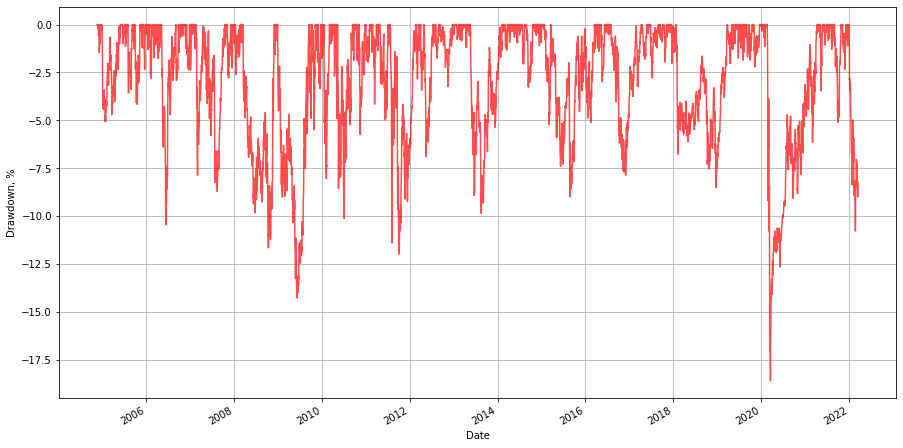

In [18]:
last_peak = cum_returns.cummax()

log_dd = cum_returns - last_peak

pct_dd = (np.exp(log_dd) - 1) * 100

ax = pct_dd.plot(figsize=(15,8), color='r', alpha=0.7)
ax.grid(axis='both')
ax.set_ylabel('Drawdown, %')

# plt.savefig('drawdown_evaluation.svg')


## Longest/max drawdowns

In [19]:

def find_true_streaks(array):
  # finds all "True" streaks in array from longest to shortest

  masked = np.concatenate(([False], array, [False]))       
  true_streaks = np.flatnonzero(masked[1:] != masked[:-1]).reshape(-1, 2) 
  ends = true_streaks[:,1]
  true_streaks_descending = (true_streaks[:,1] - true_streaks[:,0]).argsort()[::-1]
  return true_streaks[true_streaks_descending]

dd_streaks = find_true_streaks(pct_dd.values != 0)

def get_streak(n):
  start, end = dd_streaks[n]
  end = end - 1
  days = (pct_dd.index[end] - pct_dd.index[start]).days
  years = days / 365.25
  months = years * 12
  max_dd_index = start + np.argmin(pct_dd.iloc[start:end])
  max_depth = pct_dd.iloc[max_dd_index]

  return DotMap(
    rank=n+1,
    days=days,
    months=months,
    years=years,
    from_date=pct_dd.index[start].date(),
    to_date=pct_dd.index[end].date(),
    max_depth=max_depth,
    max_dd_date=pct_dd.index[max_dd_index].date(),
  )

def print_streak(n):
  streak = get_streak(n)
  print(
    f"""#{streak.rank}: Drawdown: {streak.days} days = {streak.months:.2f} months = {streak.years:.2f} years
From {streak.from_date} to {streak.to_date}""" 
  )

streaks_info = []
for i in range(12):
  if dd_streaks.size <= i: break
  streaks_info.append(get_streak(i).values())

if dd_streaks.size == 0:
  print("No drawdown found")
else:
  dd_df = pd.DataFrame(streaks_info, columns=get_streak(0).keys()).set_index(['rank'])
  pd.options.display.float_format = '{:,.2f}'.format
  print('Longest drawdowns')
  display(dd_df)
  print('By depth')
  display(dd_df.sort_values(by=['max_depth']))
  pd.options.display.float_format = None 

print()
max_dd_index = np.argmin(pct_dd)
print(f"""Absolute max drawdown {pct_dd.iloc[max_dd_index]:.2f}% on {pct_dd.index[max_dd_index].date()}""")

Longest drawdowns


,days,months,years,from_date,to_date,max_depth,max_dd_date
rank,,,,,,,
1,425,13.96,1.16,2018-01-24,2019-03-25,-8.52,2018-12-24
2,410,13.47,1.12,2020-02-24,2021-04-09,-18.60,2020-03-19
3,359,11.79,0.98,2015-03-23,2016-03-16,-9.00,2015-08-25
4,261,8.57,0.71,2013-05-22,2014-02-07,-9.86,2013-08-19
5,255,8.38,0.70,2008-03-18,2008-11-28,-11.66,2008-10-14
6,257,8.44,0.70,2008-12-31,2009-09-14,-14.28,2009-06-10
7,248,8.15,0.68,2016-08-02,2017-04-07,-7.86,2016-12-01
8,237,7.79,0.65,2007-02-22,2007-10-17,-8.72,2007-08-16
9,212,6.97,0.58,2011-07-25,2012-02-22,-11.98,2011-10-07


By depth


,days,months,years,from_date,to_date,max_depth,max_dd_date
rank,,,,,,,
2,410,13.47,1.12,2020-02-24,2021-04-09,-18.60,2020-03-19
6,257,8.44,0.70,2008-12-31,2009-09-14,-14.28,2009-06-10
9,212,6.97,0.58,2011-07-25,2012-02-22,-11.98,2011-10-07
5,255,8.38,0.70,2008-03-18,2008-11-28,-11.66,2008-10-14
12,113,3.71,0.31,2006-05-11,2006-09-01,-10.47,2006-06-14
11,123,4.04,0.34,2010-05-13,2010-09-13,-10.12,2010-07-06
4,261,8.57,0.71,2013-05-22,2014-02-07,-9.86,2013-08-19
3,359,11.79,0.98,2015-03-23,2016-03-16,-9.00,2015-08-25
8,237,7.79,0.65,2007-02-22,2007-10-17,-8.72,2007-08-16



Absolute max drawdown -18.60% on 2020-03-19


## Drawdown quantiles

Quantiles:
50.0% of time expected drawdown is no more than 2.39% theoretically or 2.55% actually
75.0% of time expected drawdown is no more than 4.77% theoretically or 5.33% actually
95.0% of time expected drawdown is no more than 10.31% theoretically or 9.28% actually
99.0% of time expected drawdown is no more than 15.85% theoretically or 12.55% actually
Max DD was 18.60%
Last DD (2022-03-16) was 8.26%


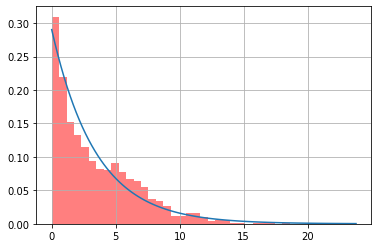

In [20]:
from scipy.stats import expon

nonzero_dd_days = -pct_dd[pct_dd < 0].sort_values()
size = nonzero_dd_days.size

nonzero_dd_days.hist(bins=32, alpha=0.5, density=True, color='red')

params = expon.fit(nonzero_dd_days)

def quantile(p):
  return expon.ppf(p, *params)

xs = np.linspace(quantile(0.001), quantile(0.999), 100)
plt.plot(xs, expon.pdf(xs, *params))

def print_quantile(p):
  theoretical = quantile(p)
  real = nonzero_dd_days[int(size * (1 - p))]
  print(f'{p * 100}% of time expected drawdown is no more than {theoretical:.2f}% theoretically or {real:.2f}% actually')

print('Quantiles:')
for p in [0.50, 0.75, 0.95, 0.99]:
  print_quantile(p)

print(f'Max DD was {nonzero_dd_days[0]:.2f}%')
print(f'Last DD ({pct_dd.index[-1].date()}) was {-pct_dd[-1]:.2f}%')

# Current portfolio state

## Structure

In [21]:
last_prices = df.iloc[-1].Close
current_portfolio = result_df.iloc[-1].portfolio
total_value = 0
for asset in current_portfolio.keys():
  total_value += last_prices[asset] * current_portfolio[asset]

for asset in current_portfolio.keys():
  print(f'{asset}: {(last_prices[asset] * current_portfolio[asset]) / total_value:.2f}%')

SPY: 0.33%
GLD: 0.33%
VNQ: 0.33%


## Channels

In [22]:
last_day = df.iloc[-1]

lower = []
upper = []
current = []
defensive = []
risk = []
for (risk_asset, config) in CONFIG.items():
  risk.append(risk_asset)
  lower.append(last_day.Lower_Channel[risk_asset])
  current.append(last_day.Close[risk_asset])
  upper.append(last_day.Upper_Channel[risk_asset])
  defensive.append(CONFIG[risk_asset]['defensive_asset'])

status_df = pd.DataFrame({
  'Defensive asset': defensive,
  'Lower': lower,
  'Current price': current,
  'Upper': upper,
  'Risk asset': risk
})
pd.options.display.float_format = '${:,.2f}'.format

# highlight current assets
current_assets = list(current_portfolio.keys())
nrows = len(status_df)

def highlight_current_asset(column_series):
  if not column_series.name in ['Risk asset', 'Defensive asset']:
    return [''] * nrows

  return [
    'background: lime; font-weight: bold'
      if row_asset == current_assets[row_index] else 
    ''
    for (row_index, row_asset) in column_series.items()
  ]

display(
  status_df.style.apply(
    highlight_current_asset,
    axis = 0
  )
)
pd.options.display.float_format = None




,Defensive asset,Lower,Current price,Upper,Risk asset
0,IEF,383.674896,430.614990,477.709991,SPY
1,TLT,161.320007,178.358002,191.509995,GLD
2,IEF,87.951675,104.250000,116.010002,VNQ
